### Load github, set working directory and install packages

In [1]:
!git clone https://github.com/AugustSchreyer/02460_Advanced_ML.git

Cloning into '02460_Advanced_ML'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 184 (delta 11), reused 37 (delta 11), pack-reused 147
Receiving objects: 100% (184/184), 341.04 MiB | 27.69 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Checking out files: 100% (32/32), done.


In [7]:
%cd /content/02460_Advanced_ML/

/content/02460_Advanced_ML


In [3]:
#!pip install arff2pandas

### Import packagages and functions

In [1]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import Tensor

from torch import nn, optim
from torch.distributions import Distribution

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
#from arff2pandas import a2p
import dill

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [2]:
from VAE.models import BaseVAEprob, BaseLSTM_VAEprob, Neural_Stat
from generators.generate_data_tfh import SERSGenerator
from utils import plot_sequences
from read_mapx import RamanExperimentData
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Data loader

(3510, 1686)
(1686,)
(45, 78)


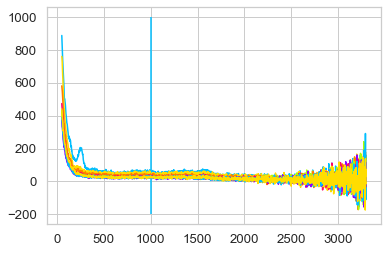

In [32]:
wavelength_cut = 1000
train_cut = 62

filenames = [
    "data/0ppm_2.mapx",
    "data/0.025ppm_2.mapx",
    "data/0.05ppm_2.mapx",
    "data/0.1ppm_2.mapx",
    "data/0.25ppm_2.mapx",
    "data/0.5ppm_2.mapx",
    "data/0.75ppm_2.mapx",
    "data/1ppm_2.mapx",
    ]

dat_class = RamanExperimentData(filenames=filenames)
spectra, w, mapsize = dat_class.maps[filenames[0]]
#spectra, w, mapsize = dat_class.read_mapx("1ppm_1.mapx")

print(spectra.shape)
print(w.shape)
print(mapsize)

for i in np.arange(0, spectra.shape[0], 500):
    plt.plot(w, spectra[i, 0:])
plt.vlines(x=1000,ymin=-200,ymax = 1000)
# We disregard all data to the right of the vertical line

### Training data is to the left, while test/validation data is on the right

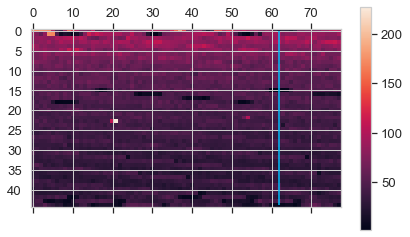

In [33]:
spectra = spectra.reshape(*mapsize, -1)
idx = np.argmin(np.abs(w - 270))
plt.matshow(spectra[:, :, idx])
plt.colorbar()
plt.vlines(x=62,ymin=44,ymax = 0)
plt.show()

In [55]:
cutoff = 200 # wavelength scale (NOT index)
train_dataset = []
validation_dataset = []

idx = np.argmin(np.abs(w-wavelength_cut))

for i in range(len(filenames)):

    dat_class = RamanExperimentData(filenames=filenames)
    spectra, w, mapsize = dat_class.maps[filenames[i]]
    
    spectra = spectra.reshape(*mapsize, -1)
    x_train = torch.from_numpy(spectra[:,:train_cut,:]).float()
    x_train = x_train.reshape(-1,len(w))
    x_train = x_train[:,:idx]
    x_val = torch.from_numpy(spectra[:,train_cut:,:]).float()
    x_val = x_val.reshape(-1,len(w))
    x_val = x_val[:,:idx] 
    
    train_dataset.append(x_train)
    validation_dataset.append(x_val)
    
    

        

train_dataset = torch.cat([s for s in train_dataset])
train_dataset = train_dataset.unsqueeze(2)

validation_dataset = torch.cat([s for s in validation_dataset])
validation_dataset = validation_dataset.unsqueeze(2)

# NS model

## Encoder/decoder

In [56]:
class Encoder_NS(nn.Module):
    def __init__(self, seq_len, n_features, hidden_dim=50, num_layers=1, bidirectional=True,
                 latent_z:int=1, z_layers:int=1, latent_c:int=1):
        super(Encoder_NS, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape((-1, self.seq_len, self.n_features))

        #(batch, hidden)
        x, (hidden_n, _) = self.lstm(x)

        if self.bidirectional:
            hidden_n = torch.cat([hidden_n[-1,:, :], hidden_n[-2,:,:]], dim=1).unsqueeze(0)
        else:
            hidden_n = hidden_n[-1, :, :]

        hidden_n = hidden_n.reshape(batch_size, -1)
        #print(hidden_n.shape)
        return hidden_n
class Decoder_NS(nn.Module):
    def __init__(self, latent_z:int, z_layers:int, latent_c:int,
                 seq_len, n_features=1, hidden_dim=50, num_layers=1, bidirectional=True):
        super(Decoder_NS, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim, self.n_features = hidden_dim, n_features
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.latent_z = latent_z
        self.z_layers = z_layers
        self.latent_c = latent_c
        
        self.lstm_depth = self.num_layers + self.num_layers * int(self.bidirectional)
        
        self.latent_to_hidden = nn.Linear(self.latent_c+self.latent_z*self.z_layers,
                                          self.hidden_dim)
        
        self.hidden_to_mu = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        self.hidden_to_sig = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        
        if torch.cuda.is_available():
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.cuda.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.cuda.FloatTensor)
        else:
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.FloatTensor)
        
        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
        # THIS LAYER CAN BE EXCLUDED
        batch_size = x.size(0)
        h_state = self.latent_to_hidden(x)        
        
        h_0 = torch.stack([h_state for _ in range(self.lstm_depth)])
        #print(f"h_0: {h_0.shape}")
        inputs = torch.stack([self.decoder_inputs for _ in range(batch_size)])
        #print(f"inputs: {inputs.shape}")
        c_inp = torch.stack([self.c_0 for _ in range(batch_size)]).permute(1,0,2).contiguous()
        #print(f"c_inp: {c_inp.shape}")
        
        decoder_output, _ = self.lstm(inputs, (h_0, c_inp))
        #print(f"DECOER OUTPUT: {decoder_output.shape}")        
        
        out_mu = self.hidden_to_mu(decoder_output).squeeze(-1)
        out_sig = self.hidden_to_sig(decoder_output).squeeze(-1)
        
        out = torch.cat([out_mu, out_sig], axis=1)
        #print(out.shape)
        
        return out

## Initialize model

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LATENT_C = 3
LATENT_Z = 3
Z_LAYERS = 3

N_FEATURES = 1
HIDDEN_DIM = 100
NUM_LAYERS = 2
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
bidirectional = True
BETA = 0.01
seq_len = idx
BETA1 = 0.1
BETA2 = 0.1

encoder = Encoder_NS(seq_len=seq_len, n_features=N_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, bidirectional=bidirectional).to(device)
decoder = Decoder_NS(seq_len=seq_len, latent_z = LATENT_Z,z_layers = Z_LAYERS, latent_c = LATENT_C,
                n_features=N_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, bidirectional=bidirectional).to(device)
model = Neural_Stat(Encoder = encoder, Decoder=decoder,
                    seq_len=seq_len, latent_z = LATENT_Z,z_layers = Z_LAYERS, latent_c = LATENT_C,
                n_features=N_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, bidirectional=bidirectional,
                beta1=BETA1,beta2=BETA2).to(device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#FOR NOW VALIDATION IS SAME AS TRAINING...
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import defaultdict
#training_data = defaultdict(list)
#validation_data = defaultdict(list)

#epoch=0

In [58]:
NUM_EPOCHS = 1000
LOSS_LIST = []
KL_c_LOSS_LIST = []
KL_z_i_LOSS_LIST = []
KL_z_L_LOSS_LIST = []
RECON_LOSS_LIST = []
VAL_LOSS_LIST = []
for epoch in range(1, NUM_EPOCHS+1):
    running_loss = 0
    running_loss_kl_c = 0
    running_loss_kl_z_i = 0
    running_loss_kl_z_L = 0
    running_loss_recon = 0
    count = 0
    model.train()

    if epoch > 300:
        model.beta1 = 10 * epoch / NUM_EPOCHS
        model.beta2 = 10 * epoch / NUM_EPOCHS

    for batch in train_loader:
        count += len(batch)/BATCH_SIZE
        batch = batch.to(device)

        loss, diagnostics, outputs = model.elbo(batch)
        running_loss -= loss.item()
        running_loss_kl_c += diagnostics["kl_c"].mean()
        running_loss_kl_z_i += diagnostics["kl_z_i"].mean()
        running_loss_kl_z_L += diagnostics["kl_z_L"].mean()
        running_loss_recon += diagnostics["log_px"].mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss_epoch = running_loss/count
    LOSS_LIST.append(avg_loss_epoch)
    
    kl_c_loss_epoch = running_loss_kl_c/count
    KL_c_LOSS_LIST.append(kl_c_loss_epoch)

    kl_z_L_loss_epoch = running_loss_kl_z_L/count
    KL_z_L_LOSS_LIST.append(kl_z_L_loss_epoch)

    kl_z_i_loss_epoch = running_loss_kl_z_i/count
    KL_z_i_LOSS_LIST.append(kl_z_i_loss_epoch)
    
    recon_loss_epoch = running_loss_recon/count
    RECON_LOSS_LIST.append(recon_loss_epoch)
    
    with torch.no_grad():
        model.eval()
        
        # Just load a single batch from the test loader
        x = next(iter(validation_loader))
        x = x.to(device)
        val_loss, _, _ = model.elbo(x)
    
    VAL_LOSS_LIST.append(-val_loss.item())
    
    if epoch % 5 == 0:
        print(f"epoch {epoch}")
        print(f"Average ELBO: {np.mean(LOSS_LIST[-25:])}")
        print(f"Validation ELBO: {np.mean(VAL_LOSS_LIST[-25:])}")


KeyboardInterrupt: 

349